## TP8 (implementation de random forest(Tutoriel))
##    GROUPE 3 CONSTITUE DE :
##        - LEPAFO MOFFO Baurel               21S2782
##        - MANFOUO SELATSA Ridano            16U2848

In [1]:
"""
Nous commencons par importer les librarie Necessaire pour notre travail
"""
import pandas as pd
import numpy as np
from pprint import pprint
import scipy.stats as sps
dataset = pd.read_csv('data\mushroom.csv',header=None)
dataset = dataset.sample(frac=1)
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing',
'gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring',
'stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population',
'habitat']

# ici nous calculons l'entropie de notre modele
def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    
    return entropy

# Vu que nous travaillons sur les arbres de decision nous implementons le GAIN 

def InfoGain(data,split_attribute_name,target_name="target"):
    #Calcul de l'entropie totale du dataset
    total_entropy = entropy(data[target_name])
    #Calcul des valeur et des occurences des attribut decoupé
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    #calcul de l'entropie par poids
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    #calcul du Gain de notre dataset
    Information_Gain = total_entropy - Weighted_Entropy
    
    return Information_Gain

## Nous Implementons L'algorithme ID3
def ID3(data,originaldata,features,target_attribute_name="target",parent_node_class = None):
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    elif len(data)==0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],return_counts=True)[1])]

    elif len(features) ==0:
        return parent_node_class
    else:
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],return_counts=True)[1])]

    features = np.random.choice(features,size=np.int(np.sqrt(len(features))),replace=False)
    item_values = [InfoGain(data,feature,target_attribute_name) for feature in features]
    best_feature_index = np.argmax(item_values)
    best_feature = features[best_feature_index]
    tree = {best_feature:{}}
    features = [i for i in features if i != best_feature]
    for value in np.unique(data[best_feature]):
        value = value
        sub_data = data.where(data[best_feature] == value).dropna()
        subtree = ID3(sub_data,dataset,features,target_attribute_name,parent_node_class)
        tree[best_feature][value] = subtree
    return(tree)


def predict(query,tree,default = 'p'):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]]
            except:
                return default
            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result


def train_test_split(dataset):
    training_data = dataset.iloc[:round(0.75*len(dataset))].reset_index(drop=True)
    testing_data = dataset.iloc[round(0.75*len(dataset)):].reset_index(drop=True)
    return training_data,testing_data
training_data = train_test_split(dataset)[0]
testing_data = train_test_split(dataset)[1]


#Entrainement du random forest

def RandomForest_Train(dataset,number_of_Trees):
    random_forest_sub_tree = []
    for i in range(number_of_Trees):
        bootstrap_sample = dataset.sample(frac=1,replace=True)
        bootstrap_training_data = train_test_split(bootstrap_sample)[0]
        bootstrap_testing_data = train_test_split(bootstrap_sample)[1]
        random_forest_sub_tree.append(ID3(bootstrap_training_data,bootstrap_training_data,bootstrap_training_data.drop(labels=['target'],axis=1).columns))
    return random_forest_sub_tree

random_forest = RandomForest_Train(dataset,50)

#prediction pour une nouvelle instance
def RandomForest_Predict(query,random_forest,default='p'):
    predictions = []
    for tree in random_forest:
        predictions.append(predict(query,tree,default))
    return sps.mode(predictions)[0][0]

query = testing_data.iloc[0,:].drop('target').to_dict()
query_target = testing_data.iloc[0,0]
print('target: ',query_target)
prediction = RandomForest_Predict(query,random_forest)
print('prediction: ',prediction)

#test du modele et retour du taux de succes
def RandomForest_Test(data,random_forest):
    data['predictions'] = None
    for i in range(len(data)):
        query = data.iloc[i,:].drop('target').to_dict()
        data.loc[i,'predictions'] = RandomForest_Predict(query,random_forest,default='p')
        accuracy = sum(data['predictions'] == data['target'])/len(data)*100
    return accuracy

RandomForest_Test(testing_data,random_forest)                       

target:  p
prediction:  p


90.49729197439686

[77.84342688330872, 65.78040374199901, 91.08813392417528, 94.14081733136386, 88.0354505169867, 89.80797636632201, 90.49729197439686, 91.08813392417528, 89.51255539143278, 92.17134416543574, 90.89118660758247, 90.49729197439686, 92.17134416543574, 90.44805514524865, 90.20187099950763, 91.97439684884293, 91.87592319054653, 92.56523879862138, 91.62973904480552, 92.81142294436239, 91.4820285573609, 91.67897587395372, 91.82668636139833, 91.67897587395372, 91.77744953225012, 91.4820285573609, 91.4820285573609, 91.67897587395372, 91.4820285573609, 91.08813392417528]


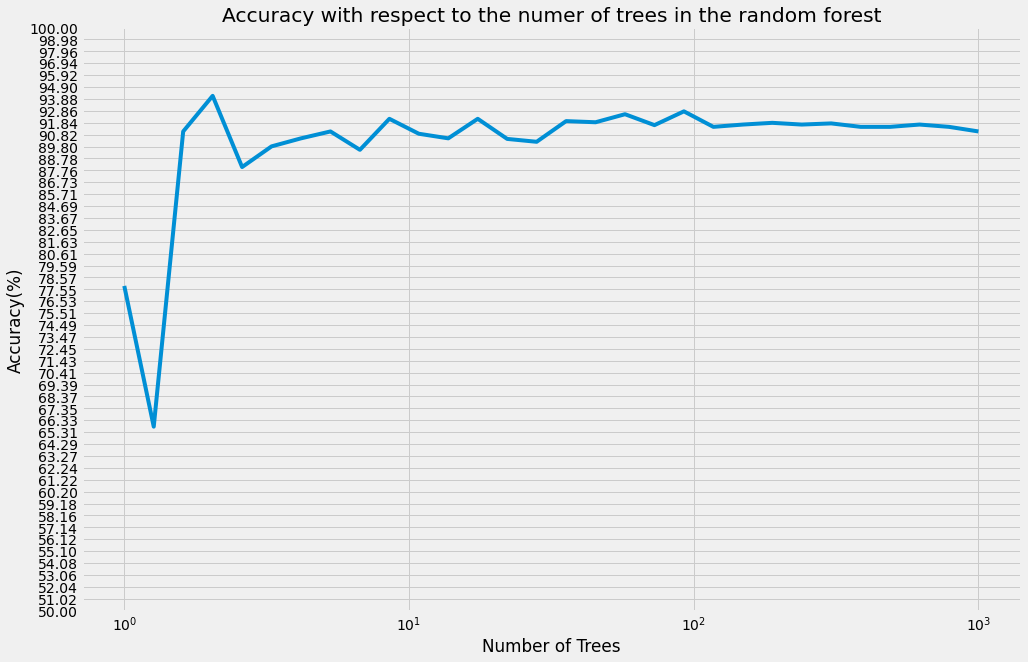

In [2]:
#Affichage des prediction en respect au nombre d'arbre de notre Random Forest

from matplotlib import style
style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,10))
ax0 = fig.add_subplot(111)
accuracy = []
for i in range(1,11,1):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
for i in range(10,110,10):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
for i in range(100,1100,100):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
print(accuracy)

ax0.plot(np.logspace(0,3,30),accuracy)
ax0.set_yticks(np.linspace(50,100,50))
ax0.set_title("Taux de succes en respect au nombre d'arbre de notre random forest")
ax0.set_xscale('log')
ax0.set_xlabel("Number of Trees")
ax0.set_ylabel('Accuracy(%)')
plt.show()

In [3]:
#implementartion des random forest avec scikit learn

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate

#Encoder les characteristique qui sont en chaine de characteres en Entier 

for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])

X = dataset.drop(['target'],axis=1)
Y = dataset['target']
#On Instancie Le modele Avec  100 Arbres et une entropy comme critere de decoupe
Random_Forest_model = RandomForestClassifier(n_estimators=100,criterion="entropy")
#Cross validation
accuracy = cross_validate(Random_Forest_model,X,Y,cv=10)['test_score']
print('Le taux de succes est: ',sum(accuracy)/len(accuracy)*100,'%')

E:\Program_Files_Disque_E\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


The accuracy is:  99.98769987699878 %
